In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from pathlib import Path
import json
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
from rastermap import Rastermap, utils
from tqdm import tqdm
from scipy.stats import zscore

root = "C://Users//Josh Selfe//OneDrive - Nexus365//Other Documents//Neuromatch"

def compute_mean_before_cue(trials, rew_positions, pre):
    """
    Aligns each trial around its reward cue position, then computes
    the mean and SEM across trials for each relative bin.
    """
    n_neurons, n_trials, n_bins = trials.shape
    pre_act = np.zeros((n_trials,n_neurons))
    window_size = pre 

    for t in range(n_trials):
        pos = int(rew_positions[t])
        start = max(pos - pre, 0)
        end   = min(pos, n_bins)

        pre_act[t,:] = trials[:, t, start:end].mean(axis=1)

        # Pad with NaN if at edges
        if pre_act[t,:].size < window_size:
            pad_left  = pre - (pos - start)
            pad_right = (end - pos - 1)
            pre_act[t,:] = np.pad(pre_act[t,:], (pad_left, pad_right), constant_values=np.nan)

    # aligned = np.stack(aligned, axis=0)  # shape (n_trials, window_size)
    # mean = np.nanmean(aligned, axis=0)
    # sem  = np.nanstd(aligned, axis=0) / np.sqrt(np.sum(~np.isnan(aligned), axis=0))
    return pre_act


In [ ]:
sel_spk = np.load(os.path.join(root, "vars", "sel_spk.npy"))

In [ ]:
Beh_test_1 = np.load(os.path.join(root, 'Beh_sup_test1.npy'), allow_pickle=1).item()
beh = Beh_test_1 ['VR2_2021_04_11_1']
sel_spk_zs = zscore(sel_spk, axis=1) 

ntrials = beh['ntrials'] # number of trials
WallName = beh['WallName'] # name of wall for each frame
cum_pos_fr = beh['ft_PosCum'] # cumulative position in decimeters for each frame

RewPos = beh['RewPos'] # position of reward in corridor
SoundPos = beh['SoundPos'] # position of sound cue in corridor 

leaf1_mask = WallName == 'leaf1'
leaf2_mask = WallName == 'leaf2'
circle1_mask = WallName == 'circle1'
circle2_mask = WallName == 'circle2'

# Extract trials along axis=1 (trial axis)
leaf1_trials = sel_spk_zs[:, leaf1_mask, :]
leaf2_trials = sel_spk_zs[:, leaf2_mask, :]
circle1_trials = sel_spk_zs[:, circle1_mask, :]
circle2_trials = sel_spk_zs[:, circle2_mask, :]

SoundPosLeaf1 = SoundPos[leaf1_mask]  # sound position for leaf1 trials
SoundPosLeaf2 = SoundPos[leaf2_mask]  # sound position for leaf2
SoundPosCircle1 = SoundPos[circle1_mask]  # sound position for leaf1 trials
SoundPosCircle2 = SoundPos[circle2_mask]  # sound position for leaf2

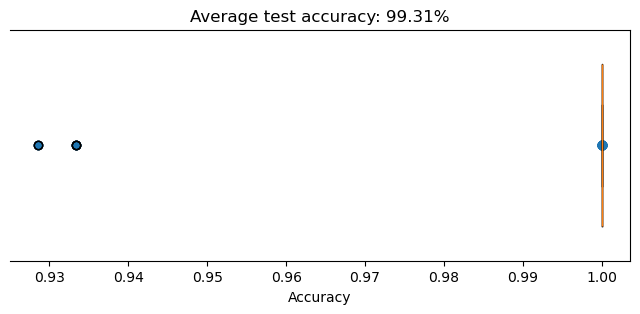

In [16]:
pre_bins = 3   # bins before cue

pre_act_leaf1 = compute_mean_before_cue(leaf1_trials[:,:,:], SoundPosLeaf1, pre_bins)
pre_act_leaf2 = compute_mean_before_cue(leaf2_trials[:,:,:], SoundPosLeaf2, pre_bins)
pre_act_circle1 = compute_mean_before_cue(circle1_trials[:,:,:], SoundPosCircle1, pre_bins)
pre_act_circle2 = compute_mean_before_cue(circle2_trials[:,:,:], SoundPosCircle2, pre_bins)

data = np.concatenate([pre_act_leaf1,pre_act_leaf2,pre_act_circle1,pre_act_circle2])
y = np.zeros(np.size(data,0))
y[:len(pre_act_leaf1)]=1
folds = 50

idx_shuffle = np.random.permutation(np.arange(np.size(data,0)))
datanew = data[idx_shuffle,:]
ynew = y[idx_shuffle]

accuracies = cross_val_score(LogisticRegression(penalty=None), data, y, cv=folds)  # k=8 cross validation
#accuracies = cross_val_score(LogisticRegression(penalty=None), datanew, ynew, cv=folds)  # k-fold cross validation

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(folds))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)
plt.show()